<a href="https://colab.research.google.com/github/thanktua-spp/machine-learning-fundamentals/blob/main/MNIST_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from IPython.core.pylabtools import figsize
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
  

## Utilities

In [73]:
def log_print(X, y, tag='Train'):
  print(f'X {tag} shape = {X.shape}')
  print(f'y {tag} shape = {y.shape}')


def norm_data(X, y):
  """
  Will also help to reshape y"""
  X_data = X / 255
  y_data = y.reshape(y.shape[0], -1)
  return X_data, y_data

def flatten(X):
  X_data = X.reshape(X.shape[0], -1)
  return X_data

def plot_images(X, y):
  plt.figure(figsize=(10,10))
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X[i])
    plt.title(y[i])
  plt.show()


def extract_classes(X, y, num_classes):
  X = X[np.where(y < num_classes)]
  y = y[y < num_classes]
  return X,y


def trim_data(X, y, ns):   
  X = X[:ns]
  y = y[:ns]
  return X, y

def predict(X_train, W):
  y_cat = np.zeros((X_train.shape[0],1))
  z = compute_z(X_train, W)
  y_pred = sigmoid(z)
  y_cat[y_pred > 0.5] = 1
  return y_cat
  

def accuracy(X, y, W):
  y_pred = predict(X, W)
  return sum(y == y_pred) / y.shape[0]


def hotencode(y):
  onehot_encoder = OneHotEncoder(sparse=False)
  if y.ndim != 2:
    y = y.reshape(-1, 1)
  return onehot_encoder.fit_transform(y)


## Import data

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [8]:
log_print(x_train, y_train)
log_print(x_test, y_test)

X Train shape = (60000, 28, 28)
y Train shape = (60000,)
X Train shape = (10000, 28, 28)
y Train shape = (10000,)


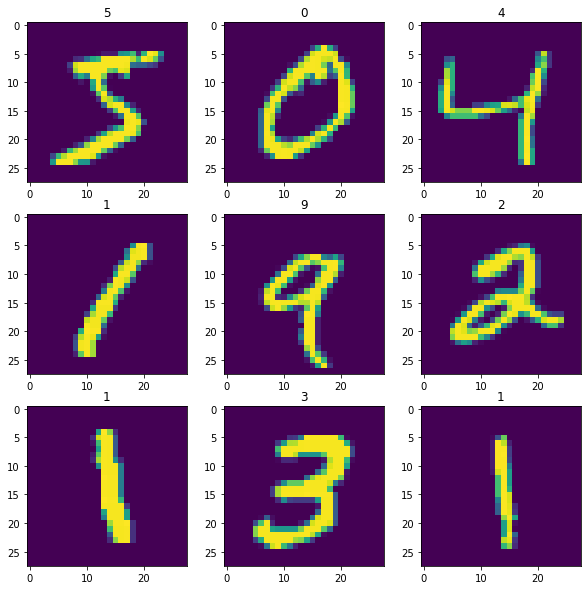

In [9]:
plot_images(x_train, y_train)

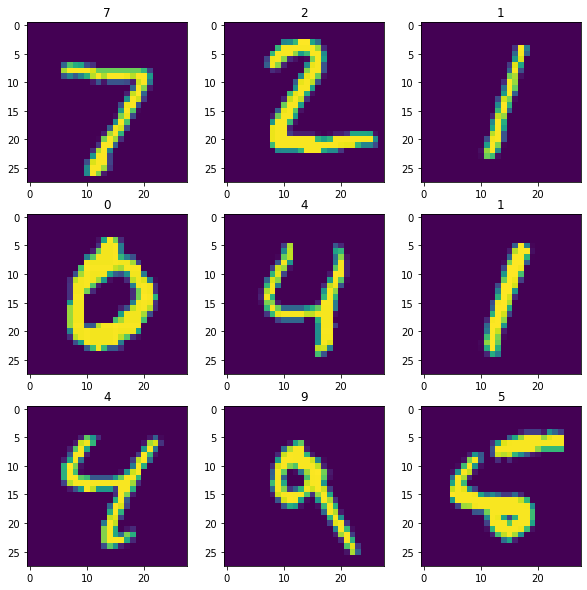

In [10]:
plot_images(x_test, y_test)

In [11]:
x_train_bin, y_train_bin = extract_classes(x_train, y_train, 2)
x_test_bin, y_test_bin = extract_classes(x_test, y_test, 2)

log_print(x_train_bin, y_train_bin)
log_print(x_test_bin, y_test_bin)

X Train shape = (12665, 28, 28)
y Train shape = (12665,)
X Train shape = (2115, 28, 28)
y Train shape = (2115,)


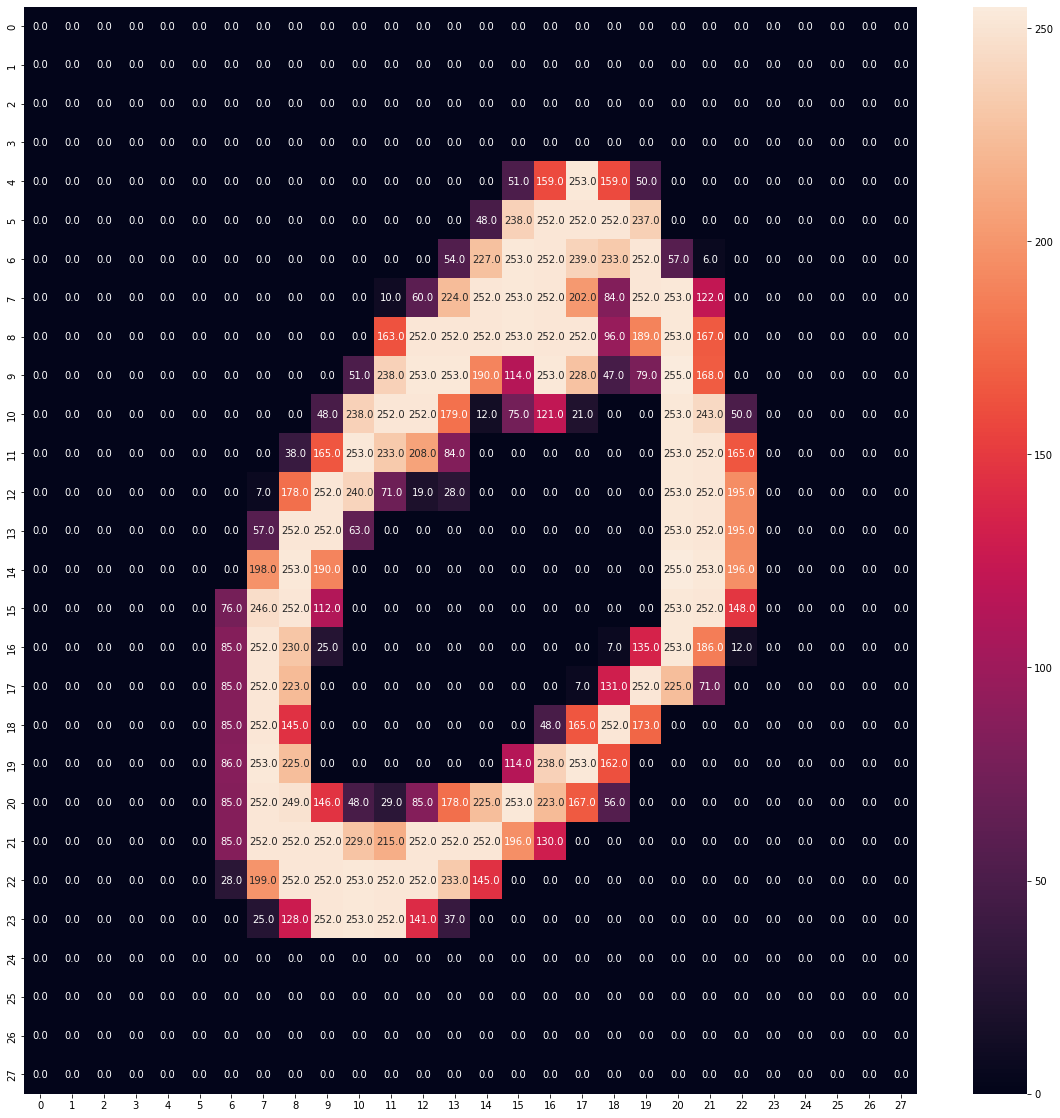

In [14]:
plt.figure(figsize=(20,20))
sns.heatmap(x_train_bin[0], annot=True, fmt='.1f')

## Data Transformation (Pre-processing)

- Normalization: Transforms each individual feature within the range of zero and o

In [15]:
log_print(x_train_bin, y_train_bin)
log_print(x_test_bin, y_train_bin)


X Train shape = (12665, 28, 28)
y Train shape = (12665,)
X Train shape = (2115, 28, 28)
y Train shape = (12665,)


In [16]:
x_train_norm, y_train_norm = norm_data(x_train_bin, y_train_bin)
x_test_norm, y_test_norm = norm_data(x_test_bin, y_test_bin)

log_print(x_train_norm, y_train_norm)
log_print(x_test_norm, y_test_norm, "Test")

print("*****************************")
x_train_flat = flatten(x_train_norm)
x_test_flat = flatten(x_test_norm)

log_print(x_train_flat, y_test_norm)
log_print(x_test_flat, y_test_norm, "Test")

X Train shape = (12665, 28, 28)
y Train shape = (12665, 1)
X Test shape = (2115, 28, 28)
y Test shape = (2115, 1)
*****************************
X Train shape = (12665, 784)
y Train shape = (2115, 1)
X Test shape = (2115, 784)
y Test shape = (2115, 1)


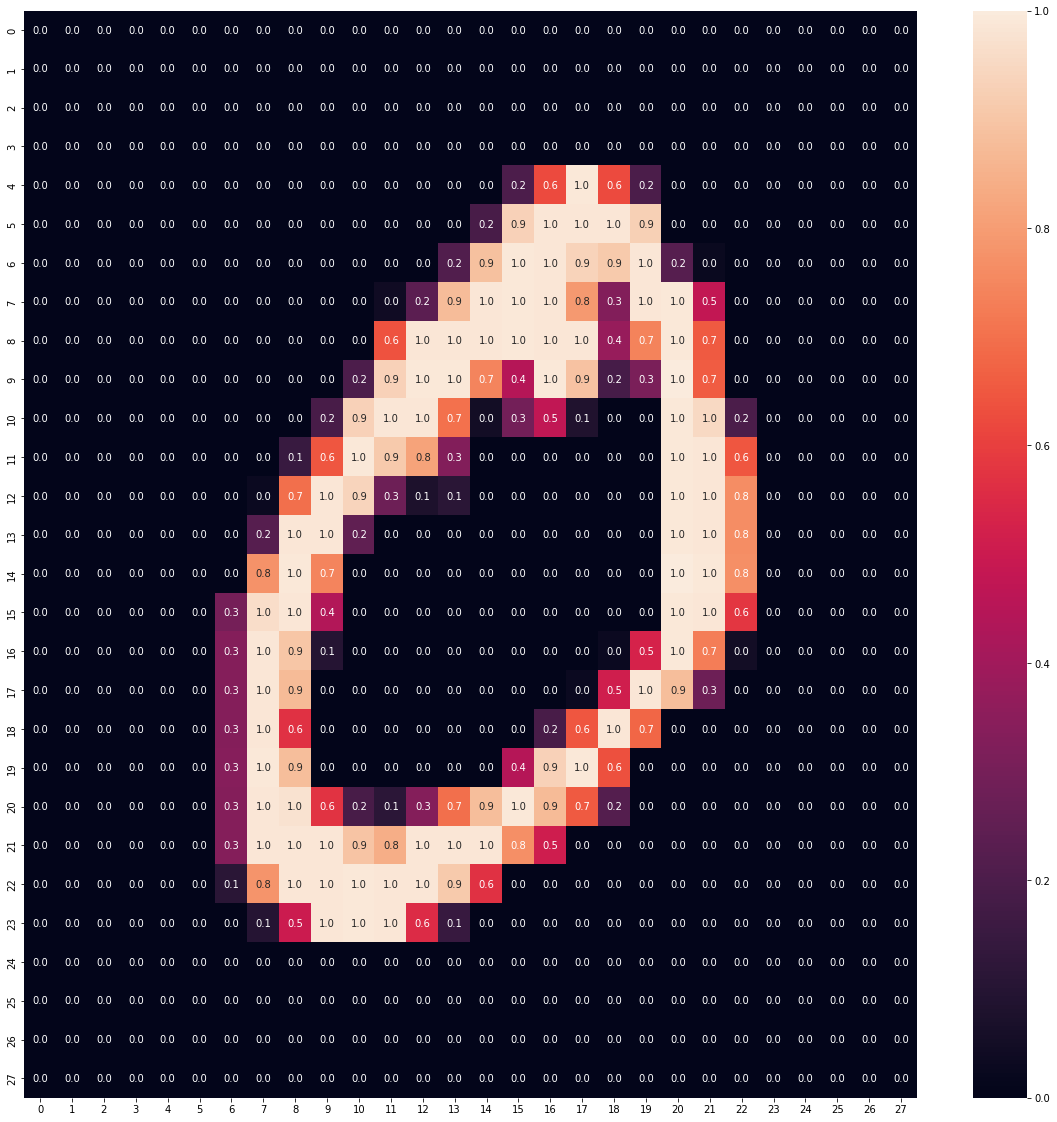

In [17]:
plt.figure(figsize=(20,20))
sns.heatmap(x_train_norm[0], annot=True, fmt='.1f')

In [18]:
ntrain_s = 500
ntest_s = 50

X_train_tr, y_train_tr = trim_data(x_train_flat, y_train_norm, ntrain_s)
X_test_tr, y_test_tr = trim_data(x_test_flat, y_test_norm, ntest_s)

log_print(X_train_tr, y_train_tr, tag='Train')
log_print(X_test_tr, y_test_tr, tag='Test')

X Train shape = (500, 784)
y Train shape = (500, 1)
X Test shape = (50, 784)
y Test shape = (50, 1)


In [ ]:
class Logistic_Regression:
  def __init__(self):
    self.model_weight = None #np.zeros((1,1))

  def _init_params(self, X_train):
    """
    Zero initialize parameters using the number of features
    """
    n_features = X_train.shape[1]
    self.model_weight = np.zeros((n_features,1))
    return self.model_weight

  def _compute_z(self, X_train):
    z = np.matmul(X_train, self.model_weight)
    return z

  def _sigmoid(self, z):
    y_hat = 1 / (1 + np.exp(-z))
    return y_hat


  def _comput_cost(self, y_train, y_hat):
    loss = -(y_train * np.log(y_hat) + (1-y_train)*np.log(1-y_hat))
    cost = np.mean(loss)  
    return cost

  def _compute_gradients(self, X_train, y_train, y_hat):
    weight_grads = (1/X_train.shape[0])*(np.dot(X_train.T, (y_hat - y_train)))
    return weight_grads

  def _update_grad(self, W_grad, lr = 0.01):
    self.model_weight = self.model_weight - lr*W_grad
    assert W_grad.shape == self.model_weight.shape
    return W_grad

  def fit_classifier(self, X_train, y_train, epochs, lr = 0.01):
    self.model_weight = self._init_params(X_train)
    
    cost_list = []
    for i in range(epochs):
      z = self._compute_z(X_train)
      y_hat = self._sigmoid(z)
      cost = self._comput_cost(y_train, y_hat)
      grads = self._compute_gradients(X_train, y_train, y_hat)
      self.model_weight = self._update_grad(grads)
      cost_list.append(cost)
      print(cost)
    return cost_list

  def predict(self, X_train):
    y_cat = np.zeros((X_train.shape[0],1))
    z = self._compute_z(X_train)
    y_pred = self._sigmoid(z)
    y_cat[y_pred > 0.5] = 1
    return y_cat


In [ ]:
model = Logistic_Regression()
model.model_weight

array([[0.]])

In [ ]:
# epochs = 5
# learning_rate = 0.001
# history =  model.fit_classifier(X_t, y_t, epochs, learning_rate)
# #binary_model.predict(X)

In [ ]:
# from sklearn.datasets import make_blobs
# X, y = make_blobs(n_samples=20, centers=2, n_features=2, cluster_std=2)
# y = y.reshape(y.shape[0],1)

2

In [19]:
def init_params(X_train):
  """
  Zero initialize parameters using the number of features
  """
  n_features = X_train.shape[1]

  # Zero_initialize
  Weight_param = np.zeros((n_features,1))

  return Weight_param


def compute_z(X_train, W):
  z = np.matmul(X_train, W)
  return z

def sigmoid(z):
  y_hat = 1 / (1 + np.exp(-z))
  return y_hat


def comput_cost(y_train, y_hat):
  assert y_train.ndim == 2
  loss = -(y_train * np.log(y_hat) + (1-y_train)*np.log(1-y_hat))
  cost = np.mean(loss)  
  return cost


def compute_gradients(X_train, y_train, y_hat):
  weight_grads = (1/X_train.shape[0])*(np.dot(X_train.T, (y_hat - y_train)))
  return weight_grads


def update_grad(W, W_grad, lr = 0.01):
  updategrads = W - lr*W_grad
  assert updategrads.shape == W.shape
  return updategrads


def fit_classifier(X_train, y_train, epochs, lr = 0.01, verbose=True):
  cost_list = []
  W = init_params(X_train)
  
  for i in range(epochs):
    z = compute_z(X_train, W)
    y_hat = sigmoid(z)
    cost = comput_cost(y_train, y_hat)
    grads = compute_gradients(X_train, y_train, y_hat)
    W = update_grad(W, grads)
    cost_list.append(cost)
    if i % 100 == 0 and verbose==True:
      print(cost)
  return cost_list, W

In [20]:
epochs = 500
cost_history, weights =  fit_classifier(X_train_tr, y_train_tr, epochs, lr = 0.01, verbose=True)

0.6931471805599454
0.11720024203137867
0.0698428363773364
0.0521861030181343
0.0427862072436316


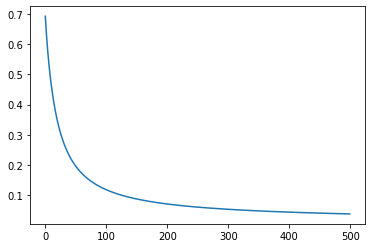

In [21]:
plt.plot(cost_history)

In [22]:
train_acc = accuracy(X_train_tr, y_train_tr, weights)
train_acc

array([0.998])

In [23]:
test_acc = accuracy(X_test_tr, y_test_tr, weights)
test_acc

array([1.])

## Usin Keras framework 

In [34]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1,  activation='softmax', input_shape=(x_train_flat.shape[1],)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 785       
                                                                 
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(
    optimizer="sgd",
    loss='bce',
    metrics=['accuracy']
)

In [36]:
history = model.fit(
          x=x_train_flat,
          y=y_train_norm,
          epochs=50,
          verbose="auto"
)

Epoch 1/50
396/396 [==============================] - 1s 1ms/step - loss: 0.1084 - accuracy: 0.5323
Epoch 2/50
396/396 [==============================] - 1s 1ms/step - loss: 0.0331 - accuracy: 0.5323
Epoch 3/50
396/396 [==============================] - 1s 1ms/step - loss: 0.0232 - accuracy: 0.5323
Epoch 4/50
396/396 [==============================] - 1s 1ms/step - loss: 0.0187 - accuracy: 0.5323
Epoch 5/50
396/396 [==============================] - 1s 2ms/step - loss: 0.0161 - accuracy: 0.5323
Epoch 6/50
396/396 [==============================] - 1s 3ms/step - loss: 0.0143 - accuracy: 0.5323
Epoch 7/50
396/396 [==============================] - 1s 1ms/step - loss: 0.0130 - accuracy: 0.5323
Epoch 8/50
396/396 [==============================] - 1s 1ms/step - loss: 0.0120 - accuracy: 0.5323
Epoch 9/50
396/396 [==============================] - 1s 1ms/step - loss: 0.0112 - accuracy: 0.5323
Epoch 10/50
396/396 [==============================] - 1s 1ms/step - loss: 0.0106 - accuracy: 0.5323

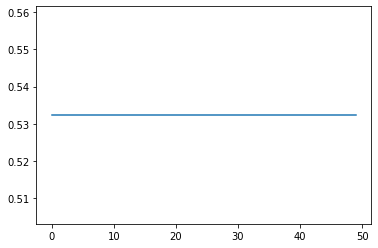

In [37]:
plt.plot(history.history['accuracy'])

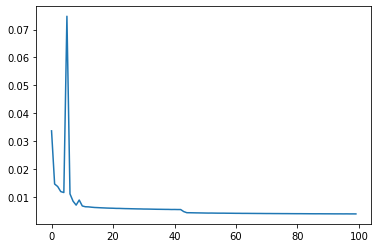

In [33]:
plt.plot(history.history['loss'])

### Extra Topics

1. Multi-class classification
2. The softmax activation and other activations
3. sgd and other optimizers
4. Layers and setting the model architecture

### Non Linear activations

#### sigmoid activation.

sigmoid activation function is computed, `sigmoid(z) = 1 / (1 + exp(-z))`

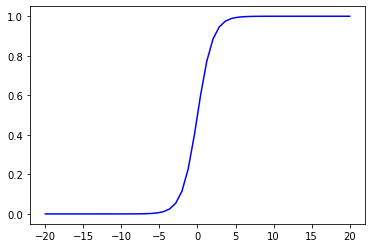

In [55]:
xrange = np.linspace(-20,20)
y_sigmoid = sigmoid(xrange)
plt.plot(xrange, y_sigmoid, 'b')

#### softmax activation.
The softmax of each vector z is computed as `softmax(z) = exp(z) /sum(exp(z))`


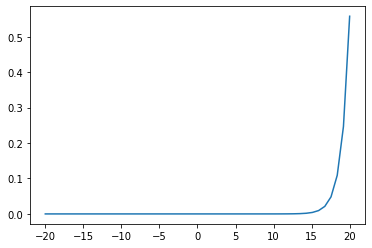

In [56]:
z = np.array([[10.2, -2, 5]])
expz = np.exp(z)
expz
def softmax(z):
  return np.exp(z)/sum(np.exp(z))

y_softmax = softmax(xrange)
plt.plot(xrange, y_softmax)

In [40]:
expz[0]/sum(expz)

0.9945087257155857

In [41]:
expz[1]/sum(expz)

5.002831995597229e-06

In [42]:
expz[2]/sum(expz)

0.005486271452418738

In [43]:
expz / sum(expz)

array([9.94508726e-01, 5.00283200e-06, 5.48627145e-03])

In [44]:
sum(expz / sum(expz))

1.0

In [57]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [ ]:
classes = {'covid', 'no covid', 'maybe'}

# Ordinal encoding
classes = {'covid':1, 'no covid':2, 'maybe':3}

actual_y = [1,
            2,
            1,
            3]
            
# One-Hot encoding  1  2  3
actual_y_encode = [[1, 0, 0],
                   [0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]]

In [61]:
y_train[:10].shape

(10,)

In [60]:
y_slice = y_train[:10]
y_slice = y_slice.reshape(-1, 1)
y_slice.shape

(10, 1)

In [62]:

# onehot_encoder = OneHotEncoder(sparse=False)
# # transform data
# result = onehot_encoder.fit_transform(y_slice)

In [65]:
result;

array([[0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.]])

In [71]:
y_train_enc =  hotencode(y_train)
y_test_enc =  hotencode(y_test)

In [79]:
# transform data
y_train_enc.shape[1]

10

In [76]:
### Model Architecture 
# Input_dim {Trainable Weights and bias from number of features}
# The first layer configuration {Units or perceptron nodes, Activations}
# (Optional) More hidden layer configuration
# Output_dim layer config {Number of ouputs for reg/class}

In [87]:
x_train_flat.shape

(12665, 784)

In [90]:
### Model Architecture 
model = tf.keras.Sequential(name='Base_Mnist')

input_shape = (x_train_flat.shape[1],)
layer_ouput = tf.keras.layers.Dense(units=y_train_enc.shape[1], activation='softmax', input_shape=input_shape)
model.add(layer_ouput)
model.summary()

Model: "Base_Mnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [102]:

# norm_data Normalize X and reshape y
x_train_norm, y_train_re = norm_data(x_train, y_train)
x_test_norm, y_test_re = norm_data(x_test, y_test)

# Flatten X
x_train_flat = flatten(x_train_norm)
x_test_flat = flatten(x_test_norm)

# Encode Y
y_train_enc =  hotencode(y_train_re)
y_test_enc =  hotencode(y_test_re)

In [105]:
x_train_norm[0];
y_train_enc;

In [121]:
### Model Architecture 
base_model = tf.keras.Sequential(name='Base_Mnist')

input_shape = (x_train_flat.shape[1],)
layer_ouput = tf.keras.layers.Dense(units=y_train_enc.shape[1], activation='softmax', input_shape=input_shape)
base_model.add(layer_ouput)
base_model.summary()


Model: "Base_Mnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [112]:
784*524 + 784*2

412384

In [132]:
### Model Architecture 
dnn_model = tf.keras.Sequential(name='Deep_Mnist')

input_shape = (x_train_flat.shape[1],)
hidden_layer1 = tf.keras.layers.Dense(units=524, activation='tanh', input_shape=input_shape)
hidden_layer2 = tf.keras.layers.Dense(units=64, activation='tanh', input_shape=input_shape)
layer_ouput = tf.keras.layers.Dense(units=y_train_enc.shape[1], activation='softmax')

dnn_model.add(hidden_layer1)
dnn_model.add(hidden_layer2)
dnn_model.add(layer_ouput)
dnn_model.summary()

Model: "Deep_Mnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 524)               411340    
                                                                 
 dense_24 (Dense)            (None, 64)                33600     
                                                                 
 dense_25 (Dense)            (None, 10)                650       
                                                                 
Total params: 445,590
Trainable params: 445,590
Non-trainable params: 0
_________________________________________________________________


In [133]:
### Model compile 
dnn_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

history = dnn_model.fit(
          x=x_train_flat,
          y=y_train_enc,
          epochs=10,
          verbose="auto"
)

Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2462 - accuracy: 0.9277
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1275 - accuracy: 0.9612
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0921 - accuracy: 0.9719
Epoch 4/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0726 - accuracy: 0.9772
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0569 - accuracy: 0.9819
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0486 - accuracy: 0.9845
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0393 - accuracy: 0.9876
Epoch 8/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0362 - accuracy: 0.9882
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0285 - accuracy: 0.9910
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - l

In [134]:
dnn_model.evaluate(x=x_test_flat, y=y_test_enc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0860 - accuracy: 0.9748


[0.08599480241537094, 0.9747999906539917]

In [127]:
dnn_model.evaluate(x=x_test_flat, y=y_test_enc)

313/313 [==============================] - 1s 3ms/step - loss: 0.2250 - accuracy: 0.9361


[0.2249845415353775, 0.9361000061035156]

In [131]:
base_model.evaluate(x=x_test_flat, y=y_test_enc)

313/313 [==============================] - 1s 1ms/step - loss: 0.2647 - accuracy: 0.9267


[0.26472198963165283, 0.9266999959945679]

In [120]:
base_model.evaluate(x=x_test_flat, y=y_test_enc)
#dnn_model.evaluate(x_test_flat)

TypeError: ignored

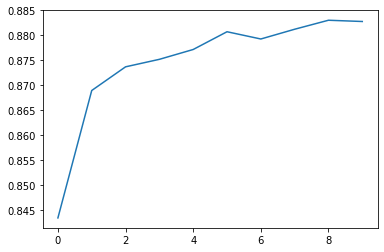

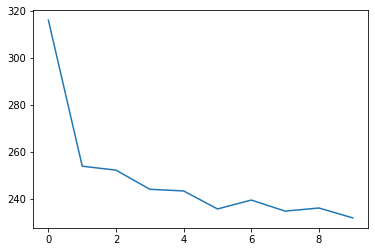

In [96]:
plt.plot(history.history['accuracy'])
plt.show()
plt.plot(history.history['loss'])
plt.show()